<a href="https://colab.research.google.com/github/audreychristensen/Bird_Audio_CNN/blob/main/1.1%20Process%20Subset%20of%20Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import numpy as np
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from PIL import Image

import soundfile as sf

import numpy as np
import cv2

import scipy.io.wavfile as wave
import scipy.ndimage as ndimage
import scipy.stats as stats
from scipy import interpolate

import os
import traceback

In [ ]:
import os
import h5py
import traceback

In [ ]:
base_dir = '/content/drive/MyDrive/F2024/Applied Data Science/Project 3/'

In [ ]:
src_dir = '/content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/'
spec_dir = '/content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality_specs_test/'

In [ ]:
# use this one
def getMelSpec(path, seconds = 5, overlap = 4, minlen = 3, winlen=0.05, winstep=0.0097, NFFT=840, sr_target=44100):
  """
  """
  y, sr = librosa.load(path, sr=sr_target)
  print(f"shape: {y.shape}", f'sr: {sr}')
  sig_splits = []
  step = int((seconds - overlap) * sr)
  window_length = int(seconds * sr)
  NFFT = max(NFFT, int(winlen * sr))

  for i in range(0, len(y), step):
    split =  y[i:i + window_length]
    if len(split) >= minlen:
      sig_splits.append(split)

  if len(sig_splits) == 0:
    sig_splits.append(sig)


  for split_sig in sig_splits:
        # compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=split_sig,
            sr=sr,
            n_fft=int(winlen * sr),
            hop_length=int(winstep * sr),
            n_mels=128*2
        )

        # Convert to dB scale
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        # resize to fixed shape
        mel_spec_resized = cv2.resize(mel_spec_db, (512, 256))

        yield mel_spec_resized


In [ ]:
def filter_isolated_cells(array, struct):

    filtered_array = np.copy(array)
    id_regions, num_ids = ndimage.label(filtered_array, structure=struct)
    id_sizes = np.array(ndimage.sum(array, id_regions, range(num_ids + 1)))
    area_mask = (id_sizes == 1)
    filtered_array[area_mask[id_regions]] = 0

    return filtered_array

In [ ]:
def hasBird(spec, threshold=16):

    #working copy
    img = spec.copy()

    #STEP 1: Median blur
    img = cv2.medianBlur(img,5)

    #STEP 2: Median threshold
    col_median = np.median(img, axis=0, keepdims=True)
    row_median = np.median(img, axis=1, keepdims=True)

    img[img < row_median * 3] = 0
    img[img < col_median * 4] = 0
    img[img > 0] = 1

    #STEP 3: Remove singles
    img = filter_isolated_cells(img, struct=np.ones((3,3)))

    #STEP 4: Morph Closing
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.float32))

    #STEP 5: Frequency crop
    img = img[128:-16, :]

    #STEP 6: Count columns and rows with signal
    #(Note: We only use rows with signal as threshold, but columns might come in handy in other scenarios)

    #column has signal?
    col_max = np.max(img, axis=0)
    col_max = ndimage.morphology.binary_dilation(col_max, iterations=2).astype(col_max.dtype)
    cthresh = col_max.sum()

    #row has signal?
    row_max = np.max(img, axis=1)
    row_max = ndimage.morphology.binary_dilation(row_max, iterations=2).astype(row_max.dtype)
    rthresh = row_max.sum()

    #final threshold
    thresh = rthresh

    #DBUGB: show?
    #print thresh
    #cv2.imshow('BIRD?', img)
    #cv2.waitKey(-1)

    #STEP 7: Apply threshold (Default = 16)
    bird = True
    if thresh < threshold:
        bird = False

    return bird, thresh

In [ ]:
birds = [src_dir + bird + '/' for bird in sorted(os.listdir(src_dir))]

In [ ]:
birds_over_50_files = []

In [ ]:
for bird in birds:
    # Get the list of files in the bird's directory (excluding subdirectories)
    files = [f for f in os.listdir(bird) if os.path.isfile(os.path.join(bird, f))]

    # Check if the number of files exceeds 100
    if len(files) > 50:
        birds_over_50_files.append(bird)

In [ ]:
bird_names = [os.path.basename(os.path.normpath(bird)) for bird in birds_over_50_files]

In [ ]:
bird_dict = {bird_name: idx for idx, bird_name in enumerate(set(bird_names))}

In [ ]:
pd.Series(bird_dict).to_csv(base_dir + 'bird_dict.csv')

In [ ]:
birds = birds_over_50_files[:5]

In [ ]:
#Specify maximum number of spectrograms per species (-1 = No limit)
MAX_SPECS = 500

#Limit number of species? (None = No limit)
MAX_SPECIES = None

In [ ]:
bird_dict

{'CarolinaWren': 0,
 'Brown-headedCowbird': 1,
 'Mallard': 2,
 'EurasianWigeon': 3,
 'CommonYellowthroat': 4,
 'NorthernFlicker': 5,
 'HornedLark': 6,
 'EasternTowhee': 7,
 'NorthernCardinal': 8,
 'WesternOsprey': 9,
 'HouseSparrow': 10,
 'AmericanCrow': 11,
 'BlueGrosbeak': 12,
 'MarshWren': 13,
 'Ovenbird': 14,
 'TuftedTitmouse': 15,
 'BarnSwallow': 16,
 'White-throatedSparrow': 17,
 'CommonTern': 18,
 'HouseWren': 19,
 'HermitThrush': 20,
 'IndigoBunting': 21,
 'HoodedWarbler': 22,
 'Dickcissel': 23,
 'AmericanRobin': 24,
 'NorthernGoshawk': 25,
 'BarredOwl': 26,
 'BlueJay': 27,
 'GreatHornedOwl': 28,
 'Grey-hoodedWarbler': 29,
 'LaplandLongspur': 30,
 'LittleGull': 31,
 'EurasianWhimbrel': 32,
 'Black-leggedKittiwake': 33,
 'Chestnut-sidedWarbler': 34,
 'RuddyTurnstone': 35,
 'Sanderling': 36,
 'EuropeanHerringGull': 37,
 'LesserBlack-backedGull': 38,
 'Gadwall': 39,
 'SavannahSparrow': 40,
 'CommonMoorhen': 41,
 'TundraSwan': 42,
 'PineWarbler': 43,
 'HouseFinch': 44,
 'AmericanRe

In [ ]:
bird_dict['AmericanCrow']

11

In [ ]:
hdf5_path = base_dir + "output_spectrograms_testing3.h5"

In [ ]:
# Define the maximum allowed duration in seconds
MAX_DURATION = 60  # For example, 30 seconds

# Function to check if the WAV file exceeds the maximum duration
def exceeds_max_duration(wav_file, max_duration=MAX_DURATION):
    # Load the WAV file
    y, sr = librosa.load(wav_file, sr=None)  # sr=None keeps the original sampling rate
    duration = librosa.get_duration(y=y, sr=sr)
    return duration > max_duration

In [ ]:
# this one should hopefully store the bird labels in a better way, also allows an option to cap number of specs

# Initialize HDF5 file
with h5py.File(hdf5_path, "w") as h5file:
    noise_group = h5file.create_group("noise")

    for bird in birds:
        bird_name = os.path.basename(os.path.normpath(bird))
        bird_group = h5file.create_group(bird_name)
        total_specs = 0

        # Get all WAV files
        wav_files = [os.path.join(bird, wav) for wav in sorted(os.listdir(bird))]

        # Parse WAV files
        for wav in wav_files:
            if exceeds_max_duration(wav):
                print(f"Skipping {wav}, as it exceeds the maximum duration of {MAX_DURATION} seconds.")
                continue  # Skip this file and move to the next

            spec_cnt = 0

            try:
                # Get every spectrogram from each WAV file
                for spec in getMelSpec(wav):
                    # Does spec contain bird sounds?
                    isbird, thresh = hasBird(spec)

                    # Choose the group for the spectrogram
                    group = bird_group if isbird else noise_group

                    # Save the spectrogram as a dataset in HDF5
                    dataset_name = (
                        f"{os.path.basename(wav).rsplit('.')[0]}_{spec_cnt}_{thresh}"
                    )
                    dataset = group.create_dataset(
                        dataset_name,
                        data=spec,
                        compression="gzip",
                        compression_opts=9,
                    )

                    # If the spectrogram is a bird sound, map it to the bird species

                    spec_cnt += 1
                    total_specs += 1

                # Exceeded spec limit?
                if total_specs >= MAX_SPECS and MAX_SPECS > -1:
                    print("")
                    break

                print("SPECS:", spec_cnt)

            except Exception as e:
                print(spec_cnt, "ERROR")
                traceback.print_exc()
                pass

print("HDF5 file created successfully.")

shape: (639360,) sr: 44100


<ipython-input-17-6aa6475a2d9a>:31: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  col_max = ndimage.morphology.binary_dilation(col_max, iterations=2).astype(col_max.dtype)
<ipython-input-17-6aa6475a2d9a>:36: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  row_max = ndimage.morphology.binary_dilation(row_max, iterations=2).astype(row_max.dtype)


SPECS: 15
shape: (329341,) sr: 44100
SPECS: 8
shape: (354125,) sr: 44100


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2205 is too large for input signal of length=1325
  warnings.warn(


SPECS: 9
shape: (2023951,) sr: 44100
SPECS: 46
shape: (772224,) sr: 44100
SPECS: 18
shape: (609639,) sr: 44100
SPECS: 14
shape: (2318976,) sr: 44100
SPECS: 53
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanCrow/568327.mp3, as it exceeds the maximum duration of 60 seconds.
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanCrow/568365.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (1428023,) sr: 44100
SPECS: 33
shape: (1841732,) sr: 44100
SPECS: 42
shape: (241575,) sr: 44100
SPECS: 6
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanCrow/574517.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (1978258,) sr: 44100
SPECS: 45
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanCrow/588916.mp3, as it exceeds the maximum duration of 60 seconds.
shape: 

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2205 is too large for input signal of length=735
  warnings.warn(


SPECS: 56
shape: (1325554,) sr: 44100
SPECS: 31
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/561402.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (1515118,) sr: 44100
SPECS: 35
shape: (802991,) sr: 44100
SPECS: 19
shape: (1218609,) sr: 44100
SPECS: 28
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/600285.mp3, as it exceeds the maximum duration of 60 seconds.
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/600286.mp3, as it exceeds the maximum duration of 60 seconds.
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/600288.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (1949714,) sr: 44100
SPECS: 45
shape: (532224,) sr: 44100
SPECS: 13
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Proje

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2205 is too large for input signal of length=1741
  warnings.warn(


SPECS: 31
shape: (1334165,) sr: 44100
SPECS: 31
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/690949.mp3, as it exceeds the maximum duration of 60 seconds.
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/690950.mp3, as it exceeds the maximum duration of 60 seconds.
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/690951.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (2425500,) sr: 44100
SPECS: 55
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRedstart/729537.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (794649,) sr: 44100


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2205 is too large for input signal of length=849
  warnings.warn(



Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRobin/522325.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (2305574,) sr: 44100
SPECS: 53
shape: (2563445,) sr: 44100
SPECS: 59
shape: (936096,) sr: 44100
SPECS: 22
shape: (1182006,) sr: 44100
SPECS: 27
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRobin/543354.mp3, as it exceeds the maximum duration of 60 seconds.
shape: (679493,) sr: 44100
SPECS: 16
shape: (376550,) sr: 44100
SPECS: 9
shape: (634042,) sr: 44100
SPECS: 15
shape: (462230,) sr: 44100
SPECS: 11
shape: (1858745,) sr: 44100
SPECS: 43
shape: (1511152,) sr: 44100
SPECS: 35
shape: (2087489,) sr: 44100
SPECS: 48
shape: (2646000,) sr: 44100
SPECS: 60
shape: (552571,) sr: 44100
SPECS: 13
shape: (1415447,) sr: 44100
SPECS: 33
shape: (2646000,) sr: 44100

shape: (1224085,) sr: 44100
SPECS: 28
Skipping /content/drive/MyDrive/F2024/Applied Data Science/Proj

In [ ]:
if os.path.exists(hdf5_path):
    print(f"HDF5 file saved at: {hdf5_path}")
else:
    print("HDF5 file was not created.")

HDF5 file saved at: output_spectrograms.h5


Testing out some of the functions as a sanity check

In [ ]:
bird_file = '/content/drive/MyDrive/F2024/Applied Data Science/Project 3/bird_calls_highest_quality/AmericanRobin/537326.mp3'

In [ ]:
y, sr = librosa.load(bird_file)

In [ ]:
ipd.Audio(bird_file)

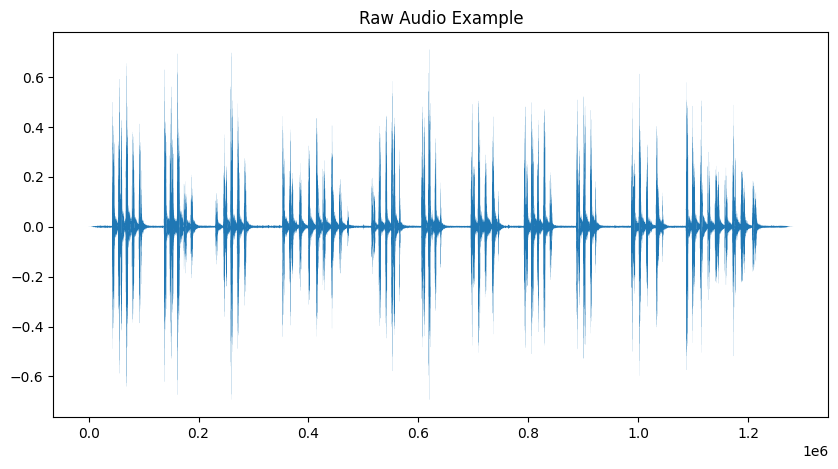

In [ ]:
pd.Series(y).plot(figsize = (10,5), lw = .05, title = 'Raw Audio Example')
plt.show()

In [ ]:
spectrograms = list(getMelSpec(bird_file))
print(f"Generated {len(spectrograms)} spectrograms.")

shape: (2563445,) sr: 44100
Generated 59 spectrograms.


In [ ]:
for spec in spectrograms:
    is_bird, thresh = hasBird(spec)
    print(f"Is bird present? {'Yes' if is_bird else 'No'}")
    print(f"Threshold value: {thresh}")

<ipython-input-27-528926af00a8>:43: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  col_max = ndimage.morphology.binary_dilation(col_max, iterations=2).astype(col_max.dtype)
<ipython-input-27-528926af00a8>:47: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  row_max = ndimage.morphology.binary_dilation(row_max, iterations=2).astype(row_max.dtype)


Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold value: 112.0
Is bird present? Yes
Threshold v

In [ ]:
f = h5py.File('/content/drive/MyDrive/F2024/Applied Data Science/Project 3/output_spectrograms_testing3.h5', 'r')

In [ ]:
list(f.keys())

['AmericanCrow',
 'AmericanRedstart',
 'AmericanRobin',
 'AmericanYellowWarbler',
 'BarnSwallow',
 'noise']

In [ ]:

with h5py.File(hdf5_path, 'r') as h5file:
    for species in h5file.keys():
        species_group = h5file[species]

        for spec_name in species_group.keys():
            spec_dataset = species_group[spec_name]

            # Get the spectrogram data
            spectrogram = spec_dataset[:]

            # Get metadata
            metadata = dict(spec_dataset.attrs)

            print(f"Spectrogram shape: {spectrogram.shape}")
            print("Metadata:", metadata)

Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram shape: (256, 512)
Metadata: {}
Spectrogram

KeyboardInterrupt: 